# HTML table to Pandas Data Frame to Portal Item

Often we read informative articles that present data in a tabular form. If such data contained location information, it would be much more insightful if presented as a cartographic map. Thus this sample shows how Pandas can be used to extract data from a table within a web page (in this case, a Wikipedia article) and how it can be then brought into the GIS for further analysis and visualization.

**Note**: to run this sample, you need a few extra libraries in your conda environment. If you don't have the libraries, install them by running the following commands from cmd.exe or your shell

```
conda install lxml
conda install html5lib
conda install beautifulsoup4
conda install matplotlib```

In [1]:
import pandas as pd

Let us read the Wikipedia article on [Estimated number of guns per capita by country](https://en.wikipedia.org/wiki/Number_of_guns_per_capita_by_country) as a pandas data frame object

In [2]:
df = pd.read_html("https://en.wikipedia.org/wiki/Number_of_guns_per_capita_by_country")[0]

Let us process the table by dropping some unncessary columns

In [3]:
df.columns = df.iloc[0]
df = df.reindex(df.index.drop(0))
df = df.reindex(df.index.drop(1))
df = df.drop(df.columns[0], axis=1)

In [4]:
df.head()

,"Country (or dependent territory, subnational area, etc.)",Estimate of civilian firearms per 100 persons,Region,Subregion,Population 2017,Estimate of firearms in civilian possession,Computation method,Registered firearms,Unregistered firearms,Notes
2,United States,120.5,Americas,Northern America,326474000,393347000,1,1073743,392273257,[note 2]
3,Falkland Islands,62.1,Americas,South America,3000,2000,2,1705,295,NaN
4,Yemen,52.8,Asia,Western Asia,28120000,14859000,2,NaN,NaN,NaN
5,New Caledonia,42.5,Oceania,Melanesia,270000,115000,2,55000,60000,NaN
6,Montenegro,39.1,Europe,Southern Europe,626000,245000,3,103536,141464,NaN


If you notice, the `Estimate of civilian firearms per 100 persons` for United States is not a proper integer. We can correct is as below

In [5]:
df.iloc[0,1] = 120.5

In [6]:
df.dtypes

0
Country (or dependent territory, subnational area, etc.)    object
Estimate of civilian firearms per 100 persons               object
Region                                                      object
Subregion                                                   object
Population 2017                                             object
Estimate of firearms in civilian possession                 object
Computation method                                          object
Registered firearms                                         object
Unregistered firearms                                       object
Notes                                                       object
dtype: object

However, we cannot change every incorrect data entry if the table is large. Further we need the `Estimate of civilian firearms per 100 persons` column in numeric format. Hence let us convert it and while doing so, convert incorrect values to `NaN` which stands for Not a Number

In [7]:
converted_column = pd.to_numeric(df["Estimate of civilian firearms per 100 persons"], errors = 'coerce')
df['Estimate of civilian firearms per 100 persons'] = converted_column
df.head()

,"Country (or dependent territory, subnational area, etc.)",Estimate of civilian firearms per 100 persons,Region,Subregion,Population 2017,Estimate of firearms in civilian possession,Computation method,Registered firearms,Unregistered firearms,Notes
2,United States,120.5,Americas,Northern America,326474000,393347000,1,1073743,392273257,[note 2]
3,Falkland Islands,62.1,Americas,South America,3000,2000,2,1705,295,NaN
4,Yemen,52.8,Asia,Western Asia,28120000,14859000,2,NaN,NaN,NaN
5,New Caledonia,42.5,Oceania,Melanesia,270000,115000,2,55000,60000,NaN
6,Montenegro,39.1,Europe,Southern Europe,626000,245000,3,103536,141464,NaN


## Plot as a map
Let us connect to our GIS to geocode this data and present it as a map

In [8]:
from arcgis.gis import GIS
import json

gis = GIS("https://www.arcgis.com", "arcgis_python", "P@ssword123")

Since the table is now using `Country (or dependent territory, subnational area, etc.)` column to signify the country code, which represents as `Country__or_dependent_territory__subnational_area__etc__` as the real column name of the table, the mapping relationship is stated as below:

In [9]:
fc = gis.content.import_data(df, {"CountryCode":"Country__or_dependent_territory__subnational_area__etc__"})

In [10]:
map1 = gis.map('UK')


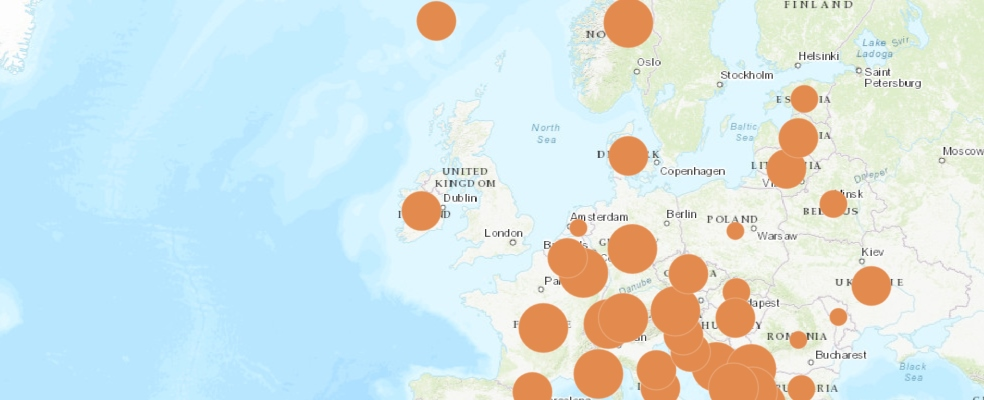

In [15]:
map1

Let us us smart mapping to render the points with varying sizes representing the number of firearms per 100 residents

In [12]:
map1.add_layer(fc, {"renderer":"ClassedSizeRenderer",
               "field_name": "Estimate_of_civilian_firearms_per_100_persons"})

Let us publish this layer as a **feature collection** item in our GIS

In [13]:
item_properties = {
    "title": "Worldwide Firearms ownership",
    "tags" : "guns,violence",
    "snippet": " GSR Worldwide firearms ownership",
    "description": "test description",
    "text": json.dumps({"featureCollection": {"layers": [dict(fc.layer)]}}),
    "type": "Feature Collection",
    "typeKeywords": "Data, Feature Collection, Singlelayer",
    "extent" : "-102.5272,-41.7886,172.5967,64.984"
}

item = gis.content.add(item_properties)

Let us search for this item

In [14]:
search_result = gis.content.search("Worldwide Firearms ownership")
search_result[0]

<Item title:"Worldwide Firearms ownership" type:Feature Collection owner:arcgis_python>